In [1]:
# Check GPU type
!nvidia-smi

Mon Nov  4 16:33:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install ultralytics
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 16.6 MB/s eta 0:00:00a 0:00:01


In [3]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Path to where your data is stored
DATA_DIR = Path('/kaggle/input')

# Preview data files available
os.listdir(DATA_DIR)

['csvs-files',
 'best_model',
 'cos711-original-images',
 'cos711-negative-images']

In [5]:
# Set up directoris for training a yolo model

DATASET_DIR = Path('/kaggle/working/data/datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

Class counts in Test.csv:
class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64


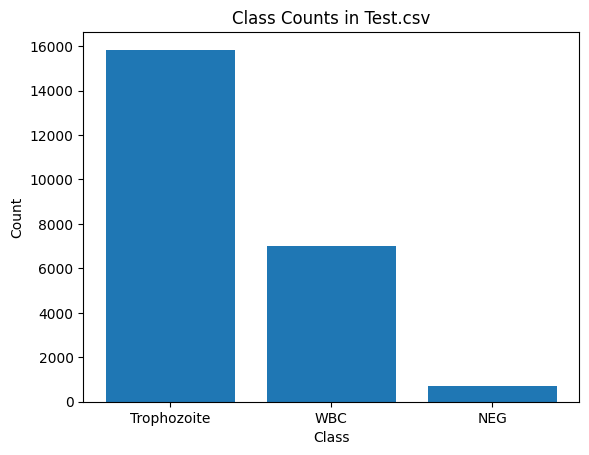

In [6]:
def EDA(train_csv):
    # get unique images from Test.csv
    images = train_csv["Image_ID"]

    # count instances of WBC, Trophozoite and NEG in the class column
    class_counts = pd.Index(train_csv['class']).value_counts()

    # print the results
    print("Class counts in Test.csv:")
    print(class_counts)

    # Graph the class counts into histograms
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Counts in Test.csv')
    plt.show()
    
train = pd.read_csv(DATA_DIR / 'csvs-files/Train.csv')
EDA(train)

In [7]:
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
    if DIR.exists():
        shutil.rmtree(DIR)
    DIR.mkdir(parents=True, exist_ok = True)

In [8]:
                 
                
# ----------------------------------------------------------------
data_path = '/kaggle/input/cos711-original-images'

AUG_TRAIN_DIR = Path(f'{data_path}/train')
AUG_VAL_DIR = Path(f'{data_path}/val')
AUG_TEST_DIR = Path(f'{data_path}/test')

AUG_TRAIN_IMAGES_DIR = AUG_TRAIN_DIR / 'images'
AUG_TRAIN_LABELS_DIR = AUG_TRAIN_DIR / 'labels'
AUG_VAL_IMAGES_DIR = AUG_VAL_DIR / 'images'
AUG_VAL_LABELS_DIR = AUG_VAL_DIR / 'labels'
AUG_TEST_IMAGES_DIR = AUG_TEST_DIR / 'images'
AUG_TEST_LABELS_DIR = AUG_TEST_DIR / 'labels'

# Copy images
loc_folders = [AUG_TRAIN_IMAGES_DIR, AUG_VAL_IMAGES_DIR, AUG_TEST_IMAGES_DIR]
dest_folders = [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TEST_IMAGES_DIR]
for loc_folder, dest_folder in zip(loc_folders, dest_folders):
    for image in tqdm(os.listdir(loc_folder)):
        shutil.copy(loc_folder / image, dest_folder / image)

# Copy labels
loc_folders = [AUG_TRAIN_LABELS_DIR, AUG_VAL_LABELS_DIR, AUG_TEST_LABELS_DIR]
dest_folders = [TRAIN_LABELS_DIR, VAL_LABELS_DIR, TEST_LABELS_DIR]
for loc_folder, dest_folder in zip(loc_folders, dest_folders):
    for label in tqdm(os.listdir(loc_folder)):
        shutil.copy(loc_folder / label, dest_folder / label)

# ----------------------------------------------------------------

# # Copy negative images
neg_images_path = '/kaggle/input/cos711-negative-images/data/original_images/negative_images'
            
            
# Paths for original and duplicate NEG images
neg_images_path = '/kaggle/input/cos711-negative-images/data/original_images/negative_images'
duplication_factor = 5  # Number of times to duplicate each NEG image

for img_file in tqdm(os.listdir(neg_images_path)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(neg_images_path, img_file)

        # Copy the original image
        shutil.copy(img_path, TRAIN_IMAGES_DIR)

        # Define the destination label file
        txt_file = img_file.replace('.jpg', '.txt')
        with open(f'{TRAIN_LABELS_DIR}/{txt_file}', 'w') as file:
            file.write('2 0.5 0.5 1.0 1.0\n') # we could've loaded the .txt file but the class-id is 0 and not 2

        # Duplicate the image and label files with unique names
        img_name_no_ext = os.path.splitext(img_file)[0]
        for i in range(duplication_factor):
            # Define the new filenames for duplicates
            duplicate_img_name = f"{img_name_no_ext}_dup{i + 1}.jpg"
            duplicate_img_path = os.path.join(TRAIN_IMAGES_DIR, duplicate_img_name)

            # Copy the image to the new filename
            shutil.copy(img_path, duplicate_img_path)

            # Create a corresponding label file with the new name
            duplicate_txt_name = f"{img_name_no_ext}_dup{i + 1}.txt"
            duplicate_txt_path = os.path.join(TRAIN_LABELS_DIR, duplicate_txt_name)
            with open(duplicate_txt_path, 'w') as file:
                file.write('2 0.5 0.5 1.0 1.0\n')  # Same label data for each duplicate

            # Create a new row with the required data
            new_row = {
                'Image_ID': f"{img_name_no_ext}_dup{i + 1}.jpg",
                'class': 'NEG',
                'confidence': 1.0,
                'ymin': 0,
                'xmin': 0,
                'ymax': 0,
                'xmax': 0
            }

            train = pd.concat([train, pd.DataFrame([new_row])], ignore_index=True)
                
            

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

  0%|          | 0/1376 [00:00<?, ?it/s]

In [9]:
# Load train and test files
# train = pd.read_csv(DATA_DIR / 'csvs-files/Train.csv')
test = pd.read_csv(DATA_DIR / 'csvs-files/Test.csv')
ss = pd.read_csv(DATA_DIR / 'csvs-files/SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,images/id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,images/id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,images/id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,images/id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,images/id_6dop09rk02.jpg,2


Class counts in Test.csv:
class
Trophozoite    15838
WBC             7004
NEG             4128
Name: count, dtype: int64


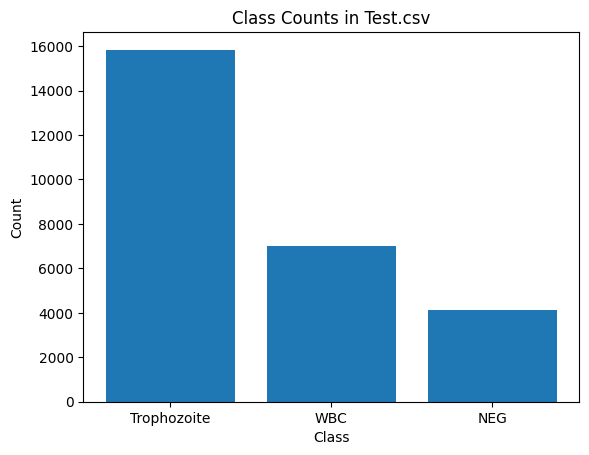

In [10]:
EDA(train)

In [11]:
# while True:
#     continue

In [12]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
# Yolo reccomends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
# train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

In [13]:
# # Split data into training and validation
# train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
# X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.2, stratify=train_unique_imgs_df['class'], random_state=42)

# X_train = train[train.Image_ID.isin(X_train.Image_ID)]
# X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# # Check shapes of training and validation data
# X_train.shape, X_val.shape

In [14]:
# Preview target distribution, seems there a class imbalance that needs to be handled
# X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

In [15]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
# for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
#   if DIR.exists():
#     shutil.rmtree(DIR)
#   DIR.mkdir(parents=True, exist_ok = True)

In [16]:
# Copy train, val and test images to their respective dirs
# for img in tqdm(X_train.image_path.unique()):
#   shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

# for img in tqdm(X_val.image_path.unique()):
#   shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

# for img in tqdm(test.image_path.unique()):
#   shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

In [17]:
# Function to convert the bboxes to yolo format and save them
# def save_yolo_annotation(row):
#     image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

#     img = cv2.imread(image_path)
#     if img is None:
#         raise ValueError(f"Could not read image from path: {image_path}")

#     height, width, _ = img.shape

#     label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

#     ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

#     # Normalize the coordinates
#     x_center = (xmin + xmax) / 2 / width
#     y_center = (ymin + ymax) / 2 / height
#     bbox_width = (xmax - xmin) / width
#     bbox_height = (ymax - ymin) / height

#     with open(label_file, 'a') as f:
#         f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# # Parallelize the annotation saving process
# def process_dataset(dataframe, output_dir):
#     dataframe['output_dir'] = output_dir
#     for row in tqdm(dataframe.to_dict('records'), total=len(dataframe)):
#         save_yolo_annotation(row)

# Save train and validation labels to their respective dirs
# process_dataset(X_train, TRAIN_LABELS_DIR)
# process_dataset(X_val, VAL_LABELS_DIR)

In [18]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('/kaggle/working/data/datasets/dataset/images/train')

In [19]:
if os._exists('/kaggle/working/runs'):
    !rm -r /kaggle/working/runs/

In [20]:
# Create a data.yaml file required by yolo
class_names = ['Trophozoite', 'WBC', 'NEG']
num_classes = len(class_names)

data_yaml = {
    'train': str(TRAIN_IMAGES_DIR),
    'val': str(VAL_IMAGES_DIR),
    'test': str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = '/kaggle/working/data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/kaggle/working/data/datasets/dataset/images/train',
 'val': '/kaggle/working/data/datasets/dataset/images/val',
 'test': '/kaggle/working/data/datasets/dataset/images/test',
 'nc': 3,
 'names': ['Trophozoite', 'WBC', 'NEG']}

Plotting id_fjqdlb0qx2_dup5.jpg with 1 bounding boxes.


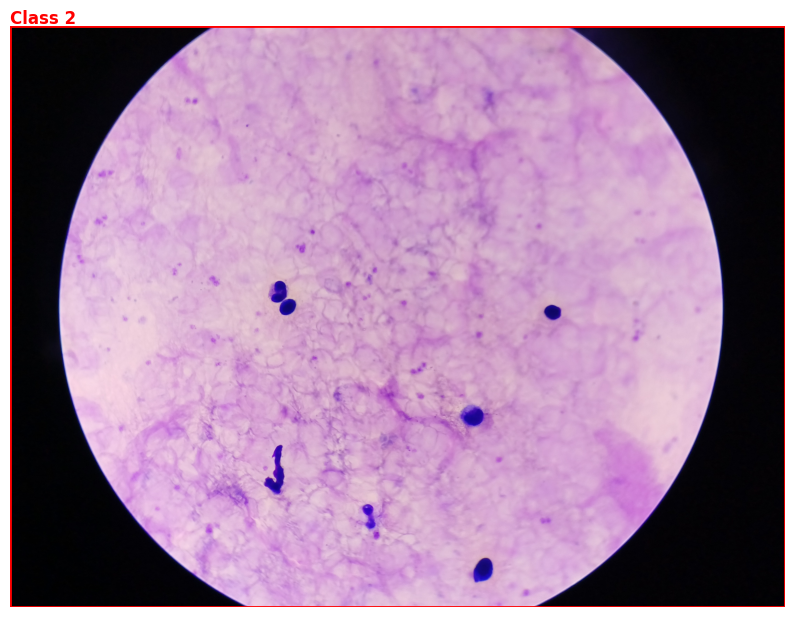

Plotting id_y77z98nfti_dup4.jpg with 1 bounding boxes.


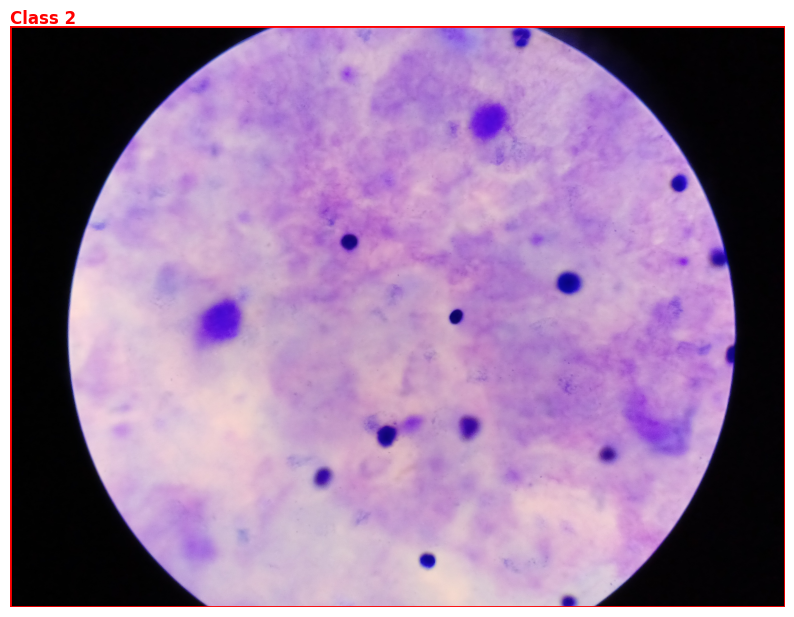

Plotting id_9rc7q09zz3.jpg with 1 bounding boxes.


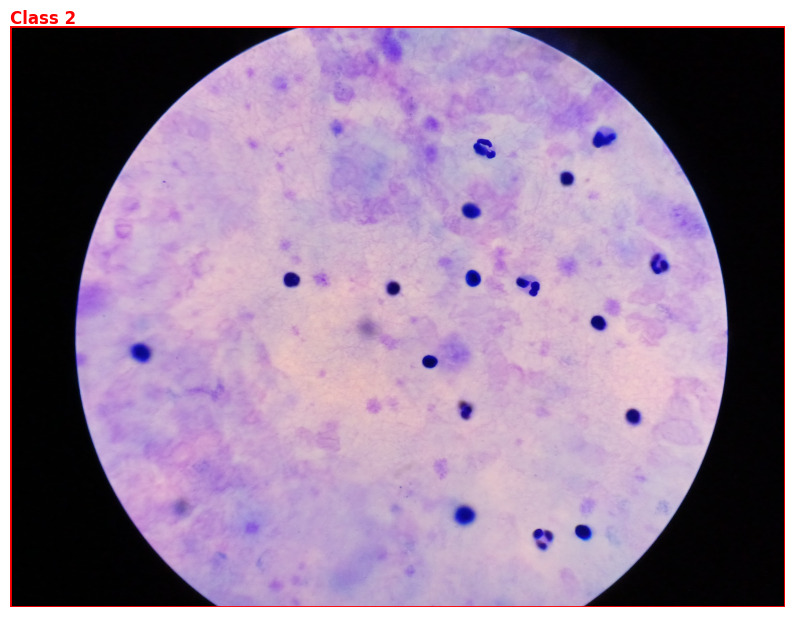

In [21]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
!pip install wandb

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
# # Load a yolo pretrained model
# model = YOLO('yolo11m.pt')

# # Fine tune model to our data
# model.train(
#     data='/kaggle/working/data.yaml',          # Path to the dataset configuration
#     epochs=30,                 # Number of epochs
#     imgsz=1024,                # Image size (height, width)
#     batch=8,                   # Batch size
#     device=0, 
#     patience=5,
#     cache=False,
#     optimizer='SGD',
#     cos_lr=True,
#     augment=True
# )

In [ ]:
# while True:
#     continue

In [ ]:
# Validate the model on the validation set
model = YOLO('/kaggle/input/best_model/other/default/1/best(1).pt')
results = model.val()

In [ ]:
# Load the trained YOLO model
model = YOLO('/kaggle/input/best_model/other/default/1/best(1).pt')

# Path to the test images directory
test_dir_path = TEST_IMAGES_DIR

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path, verbose=False)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary

    if not boxes:
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,  # You can set this to a default value
            'ymin': 0,  # Default value (no detection)
            'xmin': 0,  # Default value (no detection)
            'ymax': 0,  # Default value (no detection)
            'xmax': 0   # Default value (no detection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

In [ ]:
# Replace rows where 'class' is 'NEG'
sub.loc[sub['class'] == 'NEG', ['confidence', 'ymin', 'xmin', 'ymax', 'xmax']] = [1, 0, 0, 0, 0]

In [ ]:
sub.head()

In [ ]:
sub['class'].value_counts()

In [ ]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('/kaggle/working/benchmark_submission.csv', index = False)